############################################# SCHRODINGER EQUATION ###########################################################################
#
Continuous time-independent Schrodinger Equation ¨ Consider the one dimensional quantum harmonic oscillator defined by the Hamiltonian:
#𝐻 = 𝑝ˆ2 + 𝜔2𝑞ˆ2
(a) Write a program to compute the first 𝑘 eigenvalues 𝐸𝑘 and eigenvectors |Ψ𝑘 ⟩.
(b) How would you rate your program in terms of the priorities we introduced in class for good scientific
software development (Correctness, Stability, Accurate discretization, Flexibility, Efficiency)?
#
###############################################################################################################################################

In [1]:
# IMPORTS
import numpy as np
from numpy.polynomial.hermite import hermval
import matplotlib.pyplot as plt
import scipy
from scipy.linalg import eigh_tridiagonal, eigh
from scipy.special import factorial
from typing import Union
import os

# VISUAL OPTIONS
# print options for only 2 decimals
np.set_printoptions(precision=1)

# Eigenvalues and eigenfuncitons #

In [2]:
### EIGENVALUES AND EIGENFUNCTIONS

# Define the kinetic and potential matrices
def kinetic(a: Union[int, float], b: Union[int, float], N: int):
    
    ##  This function creates the kinetic matrix for the 1D harmonic oscillator
    ##  (to the 2nd order) given the space discretization.
    
    # Check for acceptable values of the input data
    if not isinstance(a, (int,float)):
        raise TypeError('a must be a real number!')
    
    if not isinstance(b, (int,float)):
        raise TypeError('b must be a real number!')
    
    if not isinstance(N, int):
        raise TypeError('N must be an integer number!')
    
    if b < a:
        print('b must be bigger than a.')
        exit(1)
    
    # Define the spatial discretization
    deltaX = (b - a) / N
    
    # Initialize the matrix
    mat = np.zeros((N,N))
    
    # Fill the diagonal values
    np.fill_diagonal(mat, 2)
    
    # Fill the lower and upper diagonal
    for i in range(N-1):
            mat[i,i+1] = -1
            mat[i+1,i] = -1
    
    # Multiply by the coefficient
    K = (1 / (2 * (deltaX**2))) * mat

    return K    

    ## ADD THE CASE FOR 4TH ORDER APPROX!!!!

def potential(a: Union[int, float], b: Union[int, float], N: int, omega: Union[int,float]):
    
    ##  This function creates the potential matrix for the 1D harmonic oscillator
    ##  (to the 2nd order) given the space discretization and 𝜔.
    
    # Check for acceptable values of the input data
    if not isinstance(a, (int,float)):
        raise TypeError('a must be a real number!')
    
    if not isinstance(b, (int,float)):
        raise TypeError('b must be a real number!')
    
    if not isinstance(N, int):
        raise TypeError('N must be an integer number!')
    
    if not isinstance(omega, (int,float)):
        raise TypeError('omega must be a real number!')
        
    if b < a:
        print('b must be bigger than a.')
        exit(1)
    
    # Define the spatial discretization
    deltaX = (b - a) / N
    
    # Define the spatial steps
    x_vals = np.linspace(a + deltaX, b - deltaX, N)
    
    # Initialize the matrix
    mat = np.zeros((N,N))
    
    # Fill the diagonal values
    np.fill_diagonal(mat, x_vals**2)
    
    # Multiply by the coefficient
    V = ((omega**2) / 2)  * mat

    return V

    ## ADD THE CASE FOR 4TH ORDER APPROX!!!!

def E_psi(K: np.array,V: np.array, k_max: int, diag_opt=False, flip_peak=True):
    
    ##  This function calculates the first k eigenvalues E_k
    ##  and eigenfunctions Psi_k of the 1D harmonic oscillator 
    ##  through the finite difference method at 2nd order.
    
    #   EXPLAIN THE PARAMETERS!!
    
    # Check for acceptable values of the input data
    if K.shape != V.shape:
        print('K and V must be square matrices of the same size.')
        exit(1)
    '''
    if not isinstance(K, np.array):
        raise TypeError('K must be a Numpy array!')
    
    if not isinstance(V, np.array):
        raise TypeError('V must be a Numpy array!')
    '''
    if not isinstance(k_max, int):
        raise TypeError('k must be an integer!')
    
    # Define the sum of the two matrices, S
    S = K + V     # This will be a tridiagonal matrix
    
    if diag_opt:
    # Calculate eigenvalues and eigenvectors
        diag = np.zeros(K.shape[0])
        off_diag = np.zeros(K.shape[0] - 1)
        for i in range(K.shape[0]):
            diag[i] = S[i,i]
            if i < K.shape[0] - 1:          # this is necessary to avoid an index out of range error
                off_diag[i] = S[i,i+1]
        
        # eigh_tridiagonal()'s select= and select_range= options let you compute up to the k-th eigenvalue (and eigenvectors) -> but I don't
        # do it because it messes up the normalization
        eigvals, eigvecs = eigh_tridiagonal(diag, off_diag, eigvals_only=False)  # the eigvecs are already normalized
            
    else:
        eigvals, eigvecs = eigh(S, eigvals_only=False) # the eigvecs are already normalized
    
    if flip_peak: 
        center_index = N // 2  # assuming symmetric grid centered around x = 0

        for i in range(eigvecs.shape[1]):
            if i % 2 == 0:  # Even states
            # Ensure the wavefunction is positive at the center
                if ((i//2)%2==0 and eigvecs[center_index, i] < 0) or ((i//2)%2!=0 and eigvecs[center_index, i] > 0):
                    eigvecs[:, i] *= -1
            else :  # Odd states
                # Find the first peak after the center
                for j in range(center_index, len(eigvecs[:, i]) - 1):
                    if abs(eigvecs[j, i]) > abs(eigvecs[j+1, i]):  # First peak condition
                        first_peak_index = j
                        break
                # Adjust sign based on desired pattern
                if (i % 4 == 1 and eigvecs[first_peak_index, i] < 0):  # Positive peaks
                    eigvecs[:, i] *= -1
                elif (i % 4 == 3 and eigvecs[first_peak_index, i] > 0):  # Negative peaks
                    eigvecs[:, i] *= -1
            
    return eigvals[:k_max], eigvecs[:,:k_max]

def plot_eig(eigvecs, eigvals, a, b, N, mode='Matrix'):
    ##  This function plots the eigenvalues and eigenvectors of the 1D harmonic oscillator.
    
    # Check the mode
    if mode != 'Matrix' and mode != 'Analytical':
        print('Mode not valid. Supported modes are: \'Matrix\' and \'Analytical\'')
        exit(1)
    
    # plot eigenvalues
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(eigvals) + 1), eigvals, 'o--', markersize=8, label='Eigenvalues')
    plt.grid(True)
    plt.title(f'Eigenvalues of the 1D Harmonic Oscillator ({mode})')
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
    plt.legend()
    plt.show()
    
    
    # Extract k_max
    k_max = eigvecs.shape[1]
    
    # Define the spatial steps
    x_vals = np.linspace(a, b, N)
    
    plt.figure(figsize=(16, 6))
    
    for k in range(k_max-1):
        plt.plot(x_vals, eigvecs[:, k], label=f'k={k}', alpha=0.7, color=plt.cm.viridis(k / (k_max - 1)))
    
    #plt.legend()
    plt.grid()     
    plt.title(f'Eigenfunctions ({mode})')
    plt.xlabel('X')
    plt.ylabel('|Ψk(x)⟩')
    #plt.text(0.9,0.8,f'a={a}\nb={b}')
    
    if not os.path.exists('Results'):
        os.makedirs('Results')
        
    plt.savefig(f'Results/eigenfunctions_k={k_max}_{mode}.png')
    plt.show()
    print('File succesfully saved to ./Results')

## TEST
test = False
if test:
    # Define the interval [a,b] and the space discretization Deltax = (b - a) / N
    a = -10 
    b = 10
    N = 100
    omega = 0.5
    k = 20           # number of eigenvalues and eigenvetors to be computed

    K = kinetic(a,b,N)
    V = potential(a,b,N,omega) 
    eigvals, eigvecs = E_psi(K,V,k)

    test_print = False
    if test_print:
        print(K)
        print(V)
        print(eigvals)
        print(eigvecs)
        print(eigvecs[:,0])
        print(eigvecs.shape[1])


    plot_eig(eigvecs, eigvals, a, b, N)



# Analytical comparison #

In [3]:
# Define Hermite polynomials
def hermite(x,n: int):
    
    # All coefficients of the Hermite polynomial set to zero except for the n-th, which is set to 1
    herm_coeff = np.zeros(n+1)
    herm_coeff[n] = 1
    
    # Compute the polynomial using the function from Scipy
    herm_pol = hermval(x,herm_coeff)
    
    return herm_pol
    
    
# Define the eigenvalues
def eigvals_a(omega, k_max):
    ##  This function defines the energy eigenvalues for the 1D harmonic oscillator
    #   E_n = h_bar * omega * (n + 1/2)
    #   (h_bar := 1)
    #   and return the first k eigenvalues.
        
    # Compute eigenvalues
    E_n = np.zeros(k_max)
    for k in range(k_max):
        E_n[k] = omega * (k + 1/2)
        
    
    return E_n

def eigenfs_a(omega, a, b, N, k_max, normalized=True):
    ## CALCULATE EIGENFUNCTIONS FROM THE ANALYTICAL FORMULATION
    # hermnite polinomials
    #   (h_bar := 1)
    #   mass m := 1
    
    # Define the space variable (x)
    x_vals = np.linspace(a,b,N)
    
    # Psi:
    psi = np.zeros((x_vals.shape[0],k_max))
    for k in range(k_max):
        herm = hermite(np.sqrt(omega)*x_vals, k)
        val = (1 / (np.sqrt(2**k) * factorial(k))) * \
            ((omega / np.pi)**(1/4))*np.exp(-(omega*(x_vals**2)/2))*herm
        psi[:,k] = val
    
    # Normalization of the eigenfunctions
    if normalized:
        norm = np.sqrt(sum(np.abs(psi)**2))
        psi_norm = psi / norm
    
    return psi_norm

def plot_comparison(eigvals_m, eigvecs_m, eigval_a, eigfuns_a, a, b, N):
    ##  This function plots the eigenvalues and eigenvectors of the 1D harmonic oscillator for the matrix and analytical mode in comparison.
    #
    #   Obviously, the k_max parameter must be the same for both modes
    
    # Check dimension compatibility:
    if eigvals_m.shape != eigval_a.shape:
        print('Eigenvalues arrays must have the same dimension for both modes!')
        print(f'Shapes: {eigvals_m.shape};{eigval_a.shape}')
        exit(1)
    
    elif eigvecs_m.shape != eigfuns_a.shape:
        print('Eigenvectors arrays must have the same dimension for both modes!')
        print(f'Shapes: {eigvecs_m.shape};{eigfuns_a.shape}')
        exit(1)
        
    # plot eigenvalues
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(eigvals_m) + 1), eigvals_m, 's--', markersize=8, label='Matrix', color='b', alpha=0.7)
    plt.plot(range(1, len(eigval_a) + 1), eigval_a, 'o--', markersize=8, label='Analytical', color='orange', alpha=0.7)
    plt.grid(True)
    plt.title(f'Eigenvalues of the 1D Harmonic Oscillator (comparison)')
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
    plt.legend()
    plt.show()
    
    
    # Extract k_max
    k_max = eigvecs_m.shape[1]      # thanks to the previous check, we can use this for both modes
    
    # Define the spatial steps
    x_vals = np.linspace(a, b, N)
    
    # plot eigenfunctions for the two modes 
    fig, axs = plt.subplots(2, 1, figsize=(16, 12))
    
    # Matrix
    for k in range(k_max-1):
        axs[0].plot(x_vals, eigvecs_m[:, k], label=f'k={k}', alpha=0.7, color=plt.cm.hsv(k / (k_max - 1)))
    
    axs[0].legend()
    axs[0].grid()     
    axs[0].set_title('Eigenfunctions (matrix)')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('|Ψk(x)⟩')
    
    # Analytical
    for k in range(k_max-1):
        axs[1].plot(x_vals, eigfuns_a[:, k], label=f'k={k}', alpha=0.7, color=plt.cm.hsv(k / (k_max - 1)))
    
    axs[1].legend()
    axs[1].grid()     
    axs[1].set_title('Eigenfunctions (analytical)')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('|Ψk(x)⟩')
    
    plt.tight_layout()
    plt.show()
    
    

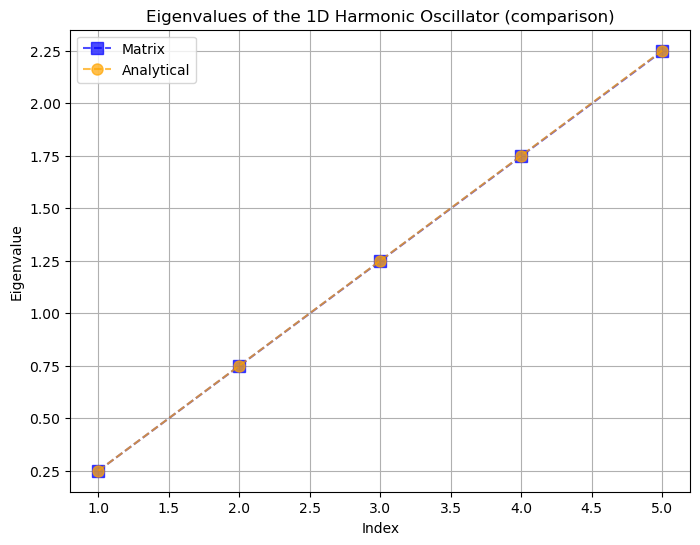

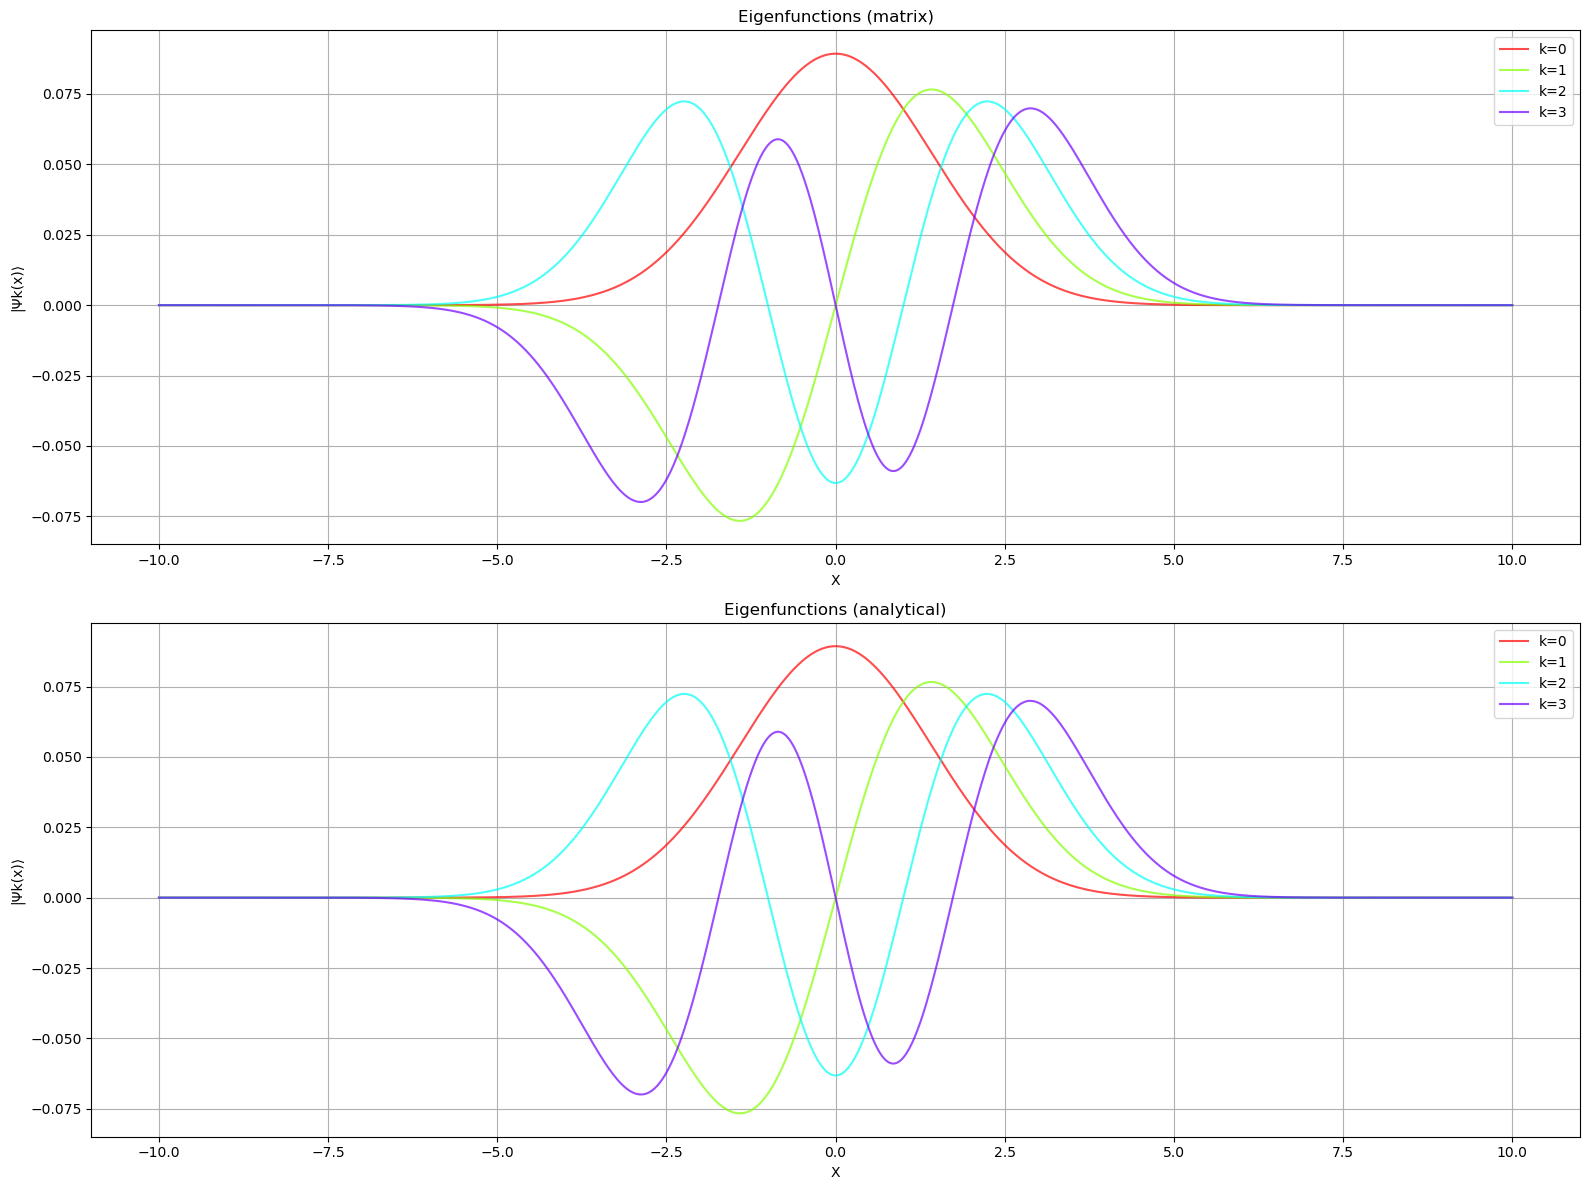

In [4]:
## I USE THE SAME PARAMETERS AS FOR THE MATRIX CASE

# Define the interval [a,b] and the space discretization Deltax = (b - a) / N
a = -10 
b = 10
N = 1000
omega = 0.5
k_max = 5           # number of eigenvalues and eigenvetors to be computed


K = kinetic(a,b,N)
V = potential(a,b,N,omega) 
eigvals_m, eigvecs_m = E_psi(K,V,k_max, diag_opt=True)

test_print_m = False
if test_print_m:
    print(K)
    print(V)
    print(eigvals_m)
    print(eigvecs_m)
    print(eigvecs_m[:,0])
    print(eigvecs_m.shape[1])

eigval_a = eigvals_a(omega, k_max)
eigfuns_a = eigenfs_a(omega, a, b, N, k_max)

test_print_a = False
if test_print_a:
    print(eigval_a)
    print(eigfuns_a)
    print(eigfuns_a[:,0])
    print(eigfuns_a.shape[1])


#plot_eig(eigfuns, eigvals, a, b, N, 'Analytical')
plot_comparison(eigvals_m, eigvecs_m, eigval_a, eigfuns_a, a, b, N)
